# ASR-SA
## Lucida AI Evaluation

### Goal
Investigate the relationship between the errors of ASR (Automatic Speech Recognition) and the errors of SA (Sentiment Analysis).

### Justification

### Experiment Setup
![alt text](exp_setup.png "exp_setup")

### Explanation

1. I chose three variants of ASR: `fisher`, `librispeech`, and `tedlium`, each corresponding to a DNN model trained on a particular dataset

2. I tested two implementations of SA: [`LSTM`](https://github.com/stanfordnlp/treelstm) and [`Google SA`](https://cloud.google.com/natural-language/).

### Generate Quries from Original Data

200 positive sentences and 200 negative sentences.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys, re, string
from operator import itemgetter
from random import shuffle
import matplotlib.pyplot as plt
fig = plt.figure()
plt.rc("font", family="serif")
plt.rc("font", size=15)

In [2]:
# Remove pucntuations from the string.
def stripped_str(str):
    return str.translate(str.maketrans('', '', string.punctuation))

# To generate the queries from the original data file,
# shuffle the original data and print 400
# (200 positive and 200 negative) unique sentences.
# (There are a lot of duplicates in the original data).
# Save the output to file `text/query.txt`.
# Original data format:
# <score>\t<sentence>
# where score is 0 (negative) or 1 (positive).
# The original data is downloaded from 
# https://inclass.kaggle.com/c/si650winter11/data.
def get_queries_from_original_data(original_data_path):
    # Print random (up to) 200 "unique" strings from the raw data lines.
    def get_random_200(lines):    
        seen = []
        i = 0
        for ans, sentence in lines:
            if i >= 200:
                break
            has_seen = False
            for s in seen:
                if stripped_str(sentence).lower() in s:
                    has_seen = True
                    break
            if has_seen:
                continue
            seen.append(stripped_str(sentence).lower())
            print('"' + sentence + '",' + str(ans))
            i += 1
            
    # Open the file and put the lines into two buckets.
    file = open(original_data_path, 'r')
    lines = file.readlines()
    pos = []
    neg = []
    for line in lines:
        ans = int(line.split('\t')[0])
        sentence = line.split('\t')[1].rstrip('\n').replace('"','')
        if ans == 1: # postive
            pos.append((ans, sentence))
        elif ans == 0: # negative
            neg.append((ans, sentence))
        else:
            raise RuntimeError
    # Randomly shuffle the buckets.
    shuffle(pos)
    shuffle(neg)
    print('query,answer')
    get_random_200(pos)
    get_random_200(neg)
    
# get_queries_from_original_data('text/original_training_data.txt')

### Generate Raw Data by Sending Queries to the Pipeline
See `README.md` for details.

### Generate `DataFrame` from ASR Results

In [3]:
# Return a DataFrame from the file with the following format:
# <audio_path>,<transcript>
# in which the audio path is of the following format:
# "path/to/file/<query_id>_<text>.wav"
# An example file:
# ../asr_sa/speech/0_Helloworld.wav,"hello world."
# Its first line must have be the header!
# The DataFrame has only one column: transcript
# with the specified header
# and sorted by the query id.
def get_df_from_asr_result(file_path, header):
    file = open(file_path, 'r')
    lines = file.readlines()
    lines.pop(0) # pop the header
    file.close()
    proc_lines = []
    for line in lines:
        line = line.lstrip().rstrip('\n')
        # The first occurrence of a number is assumed to be the query id.
        id = int(re.search(r'\d+', line).group())
        transcript = line.split(',')[1]
        if transcript.startswith('"') and transcript.endswith('"'):
            transcript = transcript[1:-1]
        proc_lines.append((id, transcript))
    proc_lines.sort(key=itemgetter(0)) # sort data by ID
    df = pd.DataFrame([row[1] for row in proc_lines], columns=[header])
    return df

data = pd.read_csv('text/query.txt')

asr_labels = ['fisher', 'librispeech', 'tedlium']

for asr_label in asr_labels:
    data = data.join \
    (get_df_from_asr_result('asr_result_{}.txt'.format(asr_label), \
                            'transcript_{}'.format(asr_label)))

### Generate `DataFrame` from LSTM Results

`LSTM` returns 1, 2, 3, 4, or 5. 

1 and 2 are turned into 0, 3 is turned into null (and thus could never be correct), 4 and 5 are turned into 1.

In [4]:
# Return a dictionary from LSTM result data.
# Format of the LSTM result data file:
# query,0,"This quiz sucks and Harry Potter sucks ok bye.."
# result,0,"4"
# where the first field is either "query" or "result",
# the second field is the query ID, 
# and the third field is the query or result based on the first field.
# There can be duplicate queries due to how Treadmill sends them.
# The dictionary maps the query string to the quantized result.
def get_dict_from_lstm_result(lstm_result_path):
    file = open(lstm_result_path, 'r')
    lines = file.readlines()
    file.close()
    query_result = {}
    id_query = {}
    for line in lines:
        line = line.rstrip('\n')
        label = line.split(',')[0]
        query_id = line.split(',')[1]
        third = line.split(',')[2:]
        third = ','.join(x for x in third)
        third = third.replace('"', '')
        if label == 'query':
            query = third
            id_query[query_id] = query
            if not query in query_result:
                query_result[query] = None
        elif label == 'result':
            result = float(third)
            query = id_query[query_id]
            if query_result[query] is None:
                # In LSTM, 0 and 1 mean negative, 
                # 3 means neutral,
                # 4 and 5 mean positive.
                # Potential problem:
                # If the result is 3, quantize into 'null',
                # which would never be correct.
                result = 1 if (int(result) > 3) else \
                'null' if (result == 3) else 0
                query_result[query] = result
#     for k, v in query_result.items():
#         print(k, v)
    return query_result

# Return a DataFrame from LSTM result data.
# In order to match the query in the LSTM result data
# to the query in `data`,
# the column name to match should be specified.
def get_df_from_lstm_result(lstm_result_path, header, data, match_col):
    query_result = get_dict_from_lstm_result(lstm_result_path)
    results = []
    for j, match_transcript in enumerate(data[match_col]):
        if match_transcript != '':
            if not match_transcript in query_result:
                raise RuntimeError('Cannot find the query ' + match_transcript)
            result = query_result[match_transcript]
        else:
            result = -1 # ASR did not return any result, so SA must be wrong!
        results.append((j, result))
    assert(len(results) == data.shape[0])
    results.sort(key=itemgetter(0)) # sort data by row index
    df = pd.DataFrame([row[1] for row in results], columns=[header])
    return df
    
sa_labels = [('fisher_lstm', 'transcript_fisher'), \
             ('librispeech_lstm', 'transcript_librispeech'), \
             ('tedlium_lstm', 'transcript_tedlium'), \
             ('regular_lstm', 'query')]

for sa_label, match_col in sa_labels:
    data = data.join \
    (get_df_from_lstm_result('sa_result_{}.txt'.format(sa_label), \
                           'answer_{}'.format(sa_label), data, \
                           match_col), lsuffix='')
    

### Generate `DataFrame` from Google SA Results

`Google SA` returns -1 or 1.

-1 is turned into 0.

In [5]:
# Return a DataFrame from Google SA result data.
# In order to match the query in the Google SA result data
# to the query in `data`,
# the column name to match should be specified.
def get_df_from_google_result(google_result_path, header, data, match_col):
    google_data = pd.read_csv(google_result_path)
    results = []
    for j, asr_output in enumerate(data[match_col]):
        match_row = -1
        if asr_output != '':
            for i, sa_input in enumerate(google_data['query']):
                if sa_input == asr_output:
                    match_row = i
                    break
            if match_row == -1:
                raise RuntimeError('Cannot find the query ' + asr_output)
            result = google_data['polarity'].ix[match_row]
            # Google returns -1 for negative and 1 for positive.
            result = 0 if (result == -1) else 1 if (result == 1) else 'null'
        else:
            result = -1 # ASR did not return any result, so SA must be wrong!
        results.append((j, result))
    assert(len(results) == data.shape[0])
    results.sort(key=itemgetter(0)) # sort data by row index
    df = pd.DataFrame([row[1] for row in results], columns=[header])
    return df
    
sa_labels = [('fisher_google', 'transcript_fisher'), \
             ('librispeech_google', 'transcript_librispeech'), \
             ('tedlium_google', 'transcript_tedlium'), \
             ('regular_google', 'query')]

for sa_label, match_col in sa_labels:
    data = data.join \
    (get_df_from_google_result('sa_result_{}.txt'.format(sa_label), \
                           'answer_{}'.format(sa_label), data, \
                           match_col), lsuffix='')
    

### Display Data as a Table

In [6]:
from IPython.display import display
pd.set_option('display.max_colwidth', -1) # display full text
data = data[['query', 'answer', 'answer_regular_lstm','answer_regular_google',  \
             'transcript_fisher', 'answer_fisher_lstm', 'answer_fisher_google', \
             'transcript_librispeech', 'answer_librispeech_lstm', 'answer_librispeech_google', \
             'transcript_tedlium', 'answer_tedlium_lstm', 'answer_tedlium_google']]
data.to_csv('data.txt') # save to disk

In [7]:
data[0:2]

,query,answer,answer_regular_lstm,answer_regular_google,transcript_fisher,answer_fisher_lstm,answer_fisher_google,transcript_librispeech,answer_librispeech_lstm,answer_librispeech_google,transcript_tedlium,answer_tedlium_lstm,answer_tedlium_google
0,Mission Impossible 3 was excellent.,1,1,0,mission impossible three was excellent.,1,1,MISSION IMPOSSIBLE THREE WAS EXCELLENT.,1,0,mission impossible three was excellent.,1,1
1,Love the Harry Potter series though I try not to talk about it too much..,1,0,1,well the harry potter series so i try not to talk about it too much.,1,0,LOVE THE HARRY POTTER SERIES THOUGH I TRY NOT TO TALK ABOUT IT TOO MUCH.,1,0,i love the harry potter series though i try not to talk about it too much.,1,1


### Interesting Observation of Google SA

Visit [Google Cloud Natural Language API (Beta)](https://cloud.google.com/natural-language/),
scroll down to the "Try the API".
First enter `MISSION IMPOSSIBLE THREE WAS excellent`,
then enter `MISSION IMPOSSIBLE THREE WAS EXCELLENT`

![alt text](google_demo_0.png "google_demo_0")

![alt text](google_demo_1.png "google_demo_1")

![alt text](google_demo_2.png "google_demo_2")

### Observation:  Polarity Word Missed, Introduced, and Contorted

1. Missed: Polarity -> Non-polarity

2. Introduced: Non-polarity -> Polarity

3. Contorted: Polarity -> Polarity

In either case, the consequence can be good, okay, or bad, depending on whether the result has the same polarity as the missed, introduced, or contorted phrase. 

In [8]:
# Introduced: "that I've read" -> "THAT A VERY BAD" (bad)
data[246:247]

,query,answer,answer_regular_lstm,answer_regular_google,transcript_fisher,answer_fisher_lstm,answer_fisher_google,transcript_librispeech,answer_librispeech_lstm,answer_librispeech_google,transcript_tedlium,answer_tedlium_lstm,answer_tedlium_google
246,"From the reviews that I've read, I hear that Brokeback Mountain is extremely depressing.",0,0,0,some reviews that either and i hear that protein buff mountain is extremely depressing.,0,0,FROM THE REVIEWS THAT A VERY BAD I HEAR THAT BROKE ABOVE MOUNTAIN IS EXTREMELY DEPRESSING.,1,0,from the reviews that either and i hear that prohibit mountain is extremely depressing.,0,0


In [9]:
# Missed: "love" -> "while of the" (bad)
data[140:141]

,query,answer,answer_regular_lstm,answer_regular_google,transcript_fisher,answer_fisher_lstm,answer_fisher_google,transcript_librispeech,answer_librispeech_lstm,answer_librispeech_google,transcript_tedlium,answer_tedlium_lstm,answer_tedlium_google
140,lol i love the mission impossible thing.(,1,1,1,oh i love the mission impossible saying.,1,1,OH I LOVE THE MISSION IMPOSSIBLE THING.,1,1,while of the mission impossible thing.,null,1


In [10]:
# Contorted: "sucks" -> "sex"/"success"
data[374:375]

,query,answer,answer_regular_lstm,answer_regular_google,transcript_fisher,answer_fisher_lstm,answer_fisher_google,transcript_librispeech,answer_librispeech_lstm,answer_librispeech_google,transcript_tedlium,answer_tedlium_lstm,answer_tedlium_google
374,"I don't understand how that pic is funny, but Harry Potter sucks anyways.",0,1,0,i don't understand how that could just funny but harry potter sex anyways.,1,0,I DON'T UNDERSTAND HOW THAT VITH HIS FUNNY BUT HARRY POTTER SEX ANYWAYS.,1,0,i don't understand found that it is funny but harry potter success anyways.,1,1


In [11]:
# Missed: "truly-awful" -> "true i also"/"trial of"
# Introduced: "chessboard" -> "just bored" (good!)
# Introduced: "looking Da" -> "loving god"
data[358:359]

,query,answer,answer_regular_lstm,answer_regular_google,transcript_fisher,answer_fisher_lstm,answer_fisher_google,transcript_librispeech,answer_librispeech_lstm,answer_librispeech_google,transcript_tedlium,answer_tedlium_lstm,answer_tedlium_google
358,"God, Yahoo Games has this truly-awful looking Da Vinci Code-themed skin on it's chessboard right now.",0,1,1,the yahoo games has that's true i also looking job and she could eat he needs to know and it's just bored right now.,0,0,THAT YOUNG WHOM JAMES HAS THIS TRUE I AWFUL LOOKING DA VINCI FOR THE HE MADE SKIN ON ITS CHESSBOARD RIGHT NOW.,1,0,that young james has this trial of a loving god and secretive he needs in on its just bored right now.,null,1


In [12]:
# Missed: "a truly beautiful film" -> "utterly the a fulfillment" (bad)
# Missed: "wept" -> "let's forceful" && "went" (good!)
data[48:49]

,query,answer,answer_regular_lstm,answer_regular_google,transcript_fisher,answer_fisher_lstm,answer_fisher_google,transcript_librispeech,answer_librispeech_lstm,answer_librispeech_google,transcript_tedlium,answer_tedlium_lstm,answer_tedlium_google
48,We went to see Brokeback Mountain which was a truly beautiful film and I'm ashamed to say I wept for a full five minutes afterwards.,1,0,0,we went to see a mountain which was really beautiful filming them ashamed to say i let's forceful five minutes afterwards.,1,1,WE WENT TO SEE ABRUPTLY BUFF MOUNTAIN WHICH WAS A TRULY BEAUTIFUL PHELIM AND I'M ASHAMED TO SAY I WEPT FOR FULL FIVE MINUTES AFTERWARDS.,1,1,we went to save a man and which was utterly the a fulfillment am ashamed to say i went for a full five minutes afterwards.,0,0


In [13]:
# Introduced: "Mountain" -> "nonsense" (okay)
# Missed: "sucked" -> "that's" (okay)
# Introduced: "Brokeback" -> "FORGIVE" (bad)
data[240:241]

,query,answer,answer_regular_lstm,answer_regular_google,transcript_fisher,answer_fisher_lstm,answer_fisher_google,transcript_librispeech,answer_librispeech_lstm,answer_librispeech_google,transcript_tedlium,answer_tedlium_lstm,answer_tedlium_google
240,Brokeback Mountain sucked.,0,0,0,but see that's nonsense that's.,0,0,FORGIVE OF MOUNTAIN SECT.,1,1,freddie that mountainside.,1,1


### Question

In [14]:
data[270:271] # why does LSTM say it is neutral?

,query,answer,answer_regular_lstm,answer_regular_google,transcript_fisher,answer_fisher_lstm,answer_fisher_google,transcript_librispeech,answer_librispeech_lstm,answer_librispeech_google,transcript_tedlium,answer_tedlium_lstm,answer_tedlium_google
270,I think I will hate Mission Impossible 3;,0,null,0,i think i really hate mission impossible street.,0,0,I THINK I WILL HATE MISSION IMPOSSIBLE FREE.,1,0,i think i will hate mission impossible three.,null,0


### Collect Statistics and Plot

In [15]:
sys.path.append('../../asr')
from wer import error_rate

# Return true if the answer is the same as the correct answer.
# Return false otherwise.
def answer_is_correct(answer, correct_answer):
    return answer == correct_answer

# Analyze the data for the specified ASR and return the statistics.
def analyze(data, asr_name, sa_name, verbose=True):
    size = data.shape[0]
    asr_errors = np.zeros(size)
    for j, transcript in enumerate(data['_'.join(['transcript', asr_name])]):
        asr_errors[j] = error_rate(data['query'][j], transcript)
    scores = np.zeros(size)
    relative_scores = np.zeros(size)
    regular_sa_result = np.zeros(size)
    sa_result = np.zeros(size)
    for j, answer in enumerate(data['_'.join(['answer', asr_name, sa_name])]):
        correct_answer = data['answer'][j]
        regular_answer = data['_'.join(['answer', 'regular', sa_name])][j]
        if answer_is_correct(regular_answer, correct_answer):
            # Regualr is correct.
            regular_sa_result[j] = 1
            if not answer_is_correct(answer, correct_answer):
                # Become wrong.
                scores[j] = 0
                relative_scores[j] = -2
            else:
                # Still correct.
                scores[j] = 1
                relative_scores[j] = 1
                sa_result[j] = 1
        else:
            # Regular is wrong.
            if not answer_is_correct(answer, correct_answer):
                # Still wrong.
                scores[j] = 0
                relative_scores[j] = -1
            else:
                # Become correct!
                scores[j] = 1
                relative_scores[j] = 2
                sa_result[j] = 1
                
    if verbose:
        wrong_indices = []
        for i, result in enumerate(sa_result):
            if result == 0:
                wrong_indices.append(i)
        print(wrong_indices)
    avg_sa_accuracy = np.count_nonzero(sa_result) / sa_result.size
    avg_regular_sa_accuracy = np.count_nonzero(regular_sa_result) / regular_sa_result.size
    print('avg_asr_error:', asr_errors.mean(), \
          'avg_sa_accuracy:', avg_sa_accuracy, \
          'avg_regular_sa_accuracy', avg_regular_sa_accuracy)
    return {'asr_name': asr_name, 'sa_name': sa_name, \
            'asr_errors': asr_errors, \
            'avg_asr_error': asr_errors.mean(), \
            'relative_scores': relative_scores, \
            'regular_sa_result': regular_sa_result, 'sa_result': sa_result, \
            'avg_sa_accuracy': avg_sa_accuracy, \
            'avg_regular_sa_accuracy': avg_regular_sa_accuracy}

# Set up plotting scheme.
fig = plt.figure()
plt.rc("font", family="serif")
plt.rc("font", size=15)

# Plot the relative scores vs error rates for a particular ASR+SA combination.
def plot_score_vs_error(color, asr_name, sa_name, asr_errors, relative_scores, **extras):
    plt.xlabel('ASR Error Rate')
    plt.ylabel('SA Relative Score')
    plt.title(' '.join([asr_name, sa_name]))
    plt.scatter(asr_errors, relative_scores, label=asr_name, color=color)

### Plot LSTM Performance

1. Baseline is LSTM with the original text query
2. Score is relative to the baseline:
    - If the baseline is correct but the ASR causes it to be wrong, the score is -2
    - If the baseline is correct and the ASR does not change the result, the score is +1
    - If the baseline is wrong and the ASR does not change the result, the score is -1
    - If the baseline is wrong but the ASR causes it to be correct, the score is +2


avg_asr_error: 0.63602837526 avg_sa_accuracy: 0.63 avg_regular_sa_accuracy 0.6475


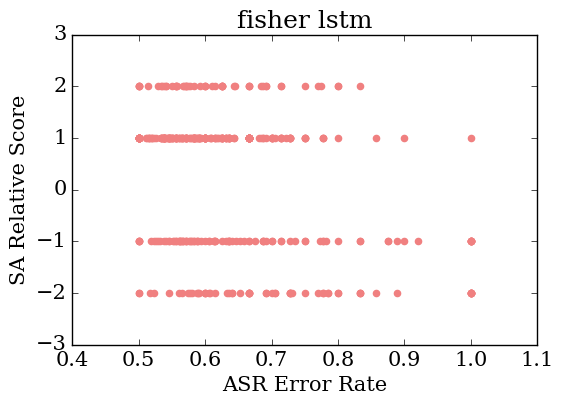

In [16]:
lstm_stats_list = []
lstm_stats_list.append(analyze(data, 'fisher', 'lstm', False))
plot_score_vs_error('lightcoral', **lstm_stats_list[-1])

avg_asr_error: 0.594927690165 avg_sa_accuracy: 0.495 avg_regular_sa_accuracy 0.6475


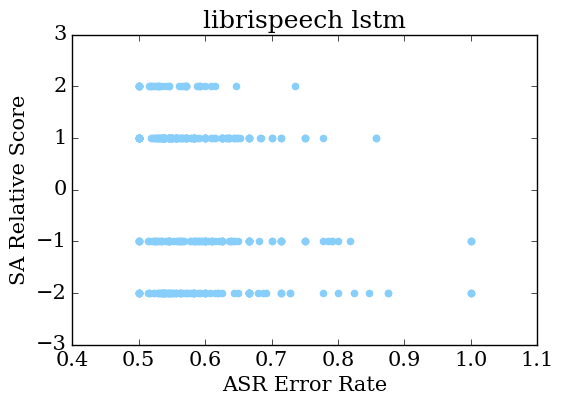

In [17]:
lstm_stats_list.append(analyze(data, 'librispeech', 'lstm', False))
plot_score_vs_error('lightskyblue', **lstm_stats_list[-1])

avg_asr_error: 0.602659786588 avg_sa_accuracy: 0.615 avg_regular_sa_accuracy 0.6475


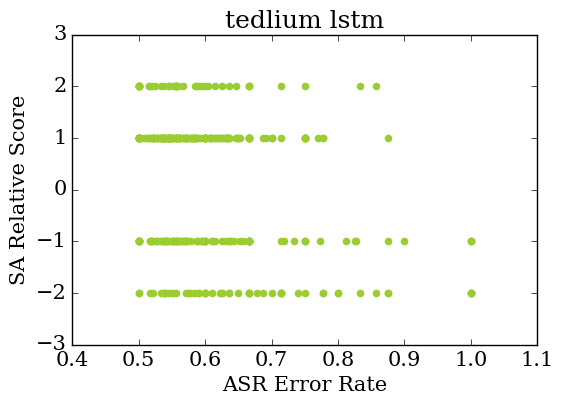

In [18]:
lstm_stats_list.append(analyze(data, 'tedlium', 'lstm', False))
plot_score_vs_error('yellowgreen', **lstm_stats_list[-1])

In [19]:
# Return the data from the list of sa statistics (one for each ASR model).
def gather_data_for_sa_vs_asr(stats_list):
    asr_name_list = [stats['asr_name'] for stats in stats_list]
    avg_asr_accuracy_list = [1 - stats['avg_asr_error'] for stats in stats_list]
    avg_sa_accuracy_list = [stats['avg_sa_accuracy'] for stats in stats_list]
    avg_regular_sa_accuracy_list = \
    [stats['avg_regular_sa_accuracy'] for stats in stats_list]
    avg_sa_accuracy_drop_list = \
    [stats['avg_sa_accuracy'] - avg_regular_sa_accuracy_list[i] \
     for i, stats in enumerate(stats_list)]
    avg_sa_accuracy_drop_percentage_list = \
    [ (avg_sa_accuracy_drop / avg_regular_sa_accuracy_list[i]) * 100 \
     for i, avg_sa_accuracy_drop in enumerate(avg_sa_accuracy_drop_list)]
    return asr_name_list, avg_asr_accuracy_list, avg_sa_accuracy_list, \
avg_regular_sa_accuracy_list, avg_sa_accuracy_drop_list, \
avg_sa_accuracy_drop_percentage_list

# Plot the performance of a particular sa under the influence of different ASR models.
def plot_sa_vs_asr(stats_list, sa_name):    
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average SA Accuracy')
    plt.title('Performace of {}\n under the influence of ASR'.format(sa_name))
    # Gather data.
    asr_name_list, avg_asr_accuracy_list, avg_sa_accuracy_list, \
    avg_regular_sa_accuracy_list, \
    avg_sa_accuracy_drop_list, avg_sa_accuracy_drop_percentage_list = \
    gather_data_for_sa_vs_asr(stats_list)
    # Plot.
    plt.scatter(avg_asr_accuracy_list, avg_sa_accuracy_list, color='orange')
    for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
        txt = '{} ({:.2f},{})\n$\Delta$Accuracy={:.2f}({:.2f}%)'.format \
        (asr_name_list[i], avg_asr_accuracy, avg_sa_accuracy_list[i], \
         avg_sa_accuracy_drop_list[i], \
         avg_sa_accuracy_drop_percentage_list[i])
        plt.annotate(txt, (avg_asr_accuracy, avg_sa_accuracy_list[i]), \
                    fontsize=10)

# Plot the performance of a different sas under the influence of different ASR models.
def plot_sas_vs_asr(list_of_stats_list, list_of_sa_name, list_of_colors):
    assert(len(list_of_stats_list) == len(list_of_sa_name))
    assert(len(list_of_sa_name) == len(list_of_colors))
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average SA Accuracy')
    plt.title('Performace of {}\nunder the influence of ASR'. \
              format(', '.join(list_of_sa_name)))
    for i, stats_list in enumerate(list_of_stats_list):
        sa_name = list_of_sa_name[i]
        # Gather data.
        asr_name_list, avg_asr_accuracy_list, avg_sa_accuracy_list, \
        avg_regular_sa_accuracy_list, \
        avg_sa_accuracy_drop_list, avg_sa_accuracy_drop_percentage_list = \
        gather_data_for_sa_vs_asr(stats_list)
        # Plot.
        plt.scatter(avg_asr_accuracy_list, avg_sa_accuracy_list, \
                    label=sa_name, color=list_of_colors[i])
        plt.legend(loc=3)
        for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
            txt = '{} ($\Delta$Accuracy {:.2f}%)'.format \
            (asr_name_list[i], avg_sa_accuracy_drop_percentage_list[i])
            plt.annotate(txt, (avg_asr_accuracy, avg_sa_accuracy_list[i]), \
                         fontsize=10)

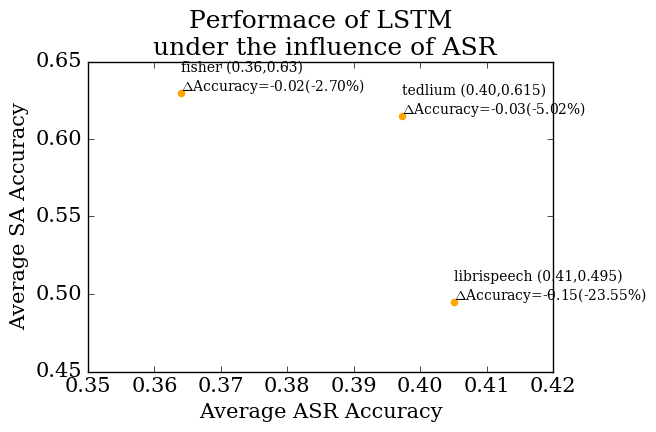

In [20]:
plot_sa_vs_asr(lstm_stats_list, 'LSTM')

### Plot Google SA Performance

avg_asr_error: 0.63602837526 avg_sa_accuracy: 0.765 avg_regular_sa_accuracy 0.8075


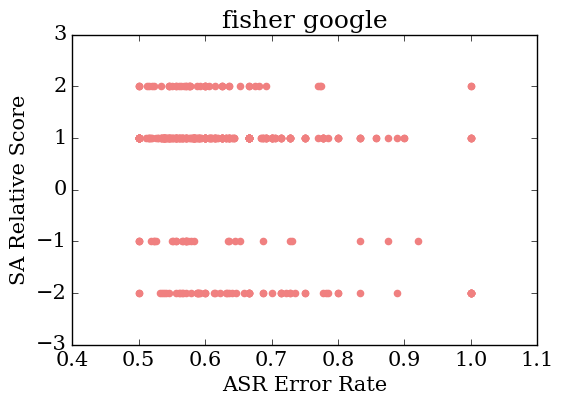

In [21]:
googlesa_stats_list = []
googlesa_stats_list.append(analyze(data, 'fisher', 'google', False))
plot_score_vs_error('lightcoral', **googlesa_stats_list[-1])

avg_asr_error: 0.594927690165 avg_sa_accuracy: 0.7025 avg_regular_sa_accuracy 0.8075


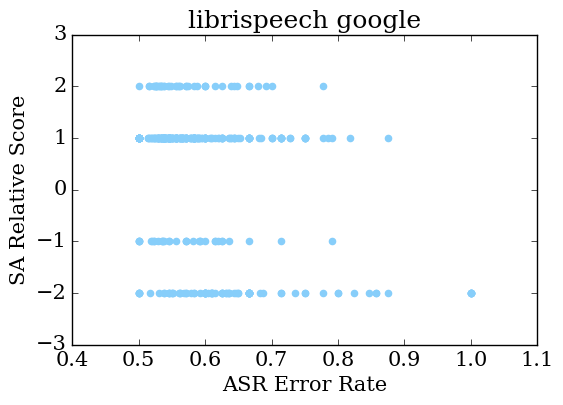

In [22]:
googlesa_stats_list.append(analyze(data, 'librispeech', 'google', False))
plot_score_vs_error('lightskyblue', **googlesa_stats_list[-1])

avg_asr_error: 0.602659786588 avg_sa_accuracy: 0.715 avg_regular_sa_accuracy 0.8075


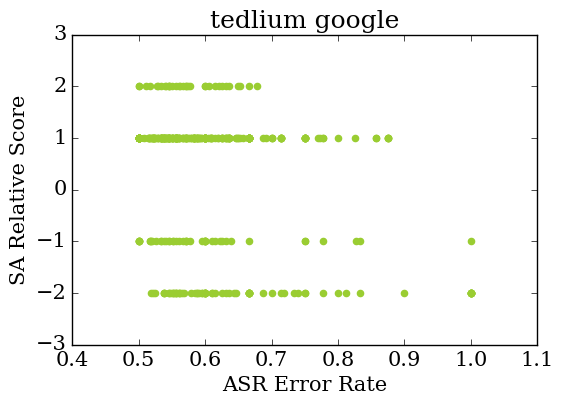

In [23]:
googlesa_stats_list.append(analyze(data, 'tedlium', 'google', False))
plot_score_vs_error('yellowgreen', **googlesa_stats_list[-1])

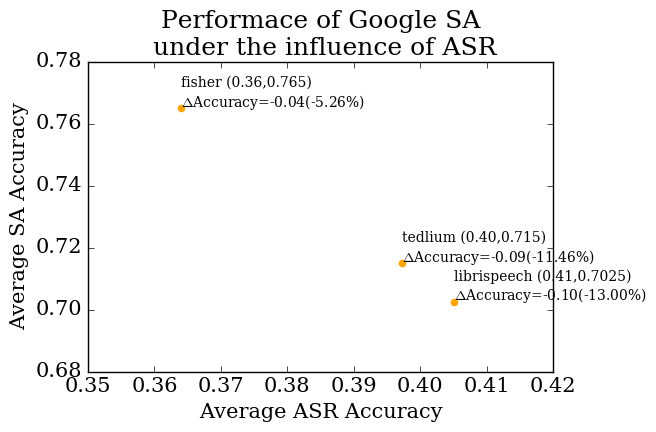

In [24]:
plot_sa_vs_asr(googlesa_stats_list, 'Google SA')

### Summary

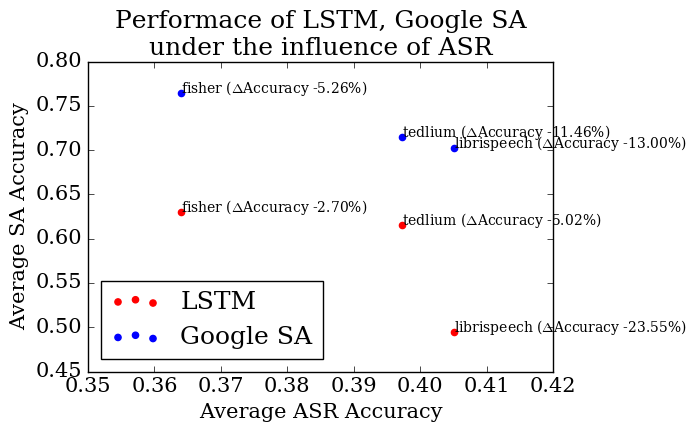

In [25]:
plot_sas_vs_asr([lstm_stats_list, googlesa_stats_list], \
                ['LSTM', 'Google SA'], ['red', 'blue'])

### Resources

1. SQuAD: The Stanford Question Answering Dataset: https://rajpurkar.github.io/SQuAD-explorer/

### Pipelines

1. ASR -> QA (✓)

2. ASR -> SA (✓)

3. ASR -> Query Classfication (Yunsheng)

4. OCR -> NER (Yunsheng)

5. OCR -> Translation (Yunsheng)

6. Summarization -> Translation (Yunsheng)

7. Image Matching -> QA (Xiaowei)

8. Image Captioning -> SA (Xiaowei)

9. ASR -> Visual QA (Xiaowei)

10. ASR/OCR -> Image Generation